In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,SimpleRNN,Flatten,Lambda,Conv1D,MaxPooling1D,BatchNormalization,Activation,Concatenate,Input,Add,Conv2D
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [ ]:
class timeSeriesPredict:
  def __init__(self,countryName):
    self.country = countryName
  series = []
  model = 0
  x = []
  y = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  split_time = 0
  lr = .001
  optimizer = Adam(lr)
  loss = tf.keras.losses.MeanSquaredError()
  callbacks = []
  epochs = 500
  history = None


In [ ]:
def get_series(file_path):
  sdate = datetime.datetime.strptime(starting_date, "%d%m%Y").date()
  with open(file_path) as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    series = []
    c = 0
    dates = []
    for i in reader:
      try : 
        tmp = []
        tmp.append(float(i[5]))
        tmp.append(float(i[8]))
        series.append(np.array(tmp))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
      except:
        series.append(np.array([0,0]))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
        continue
    series = np.vstack(series)
    return series,dates



def create_windowed_dataset(series, window,begin):
  # series is a numpy array with shape (m,n_features)
  # this function returns x and y
  # x -> windowed data, numpy array of shape (m,n_features)
  # y -> labels for x, numpy array with shape(m,)
  m, n_features = series.shape
  i = begin
  x = []
  y = []
  while i < m :
    tmp = np.zeros((window,n_features))
    j = 0 if i-window >= 0 else window - i;
    tmp[j:window,:] = series[max(0,i-window):i,:] 
    x.append(tmp)
    y.append(series[i])
    i += 1
  return np.array(x), np.array(y)

def train_test_split(ratio,x,y):
  split_time = int(x.shape[0] * ratio)
  return x[0:split_time,:],x[split_time:,:],y[0:split_time],y[split_time:]

def moving_average(series,window):
  x = []
  m = series.shape[0]
  for i in range(m):
    b = i - window//2
    e = i + window//2
    inc = 0 if b > 0 else -b
    e += inc
    b += inc
    dec = 0 if e < m else e-m+1
    b -= dec
    e -= dec
    # print(b,e)
    # print(np.sum(series[b:e+1,:],axis=0))
    x.append(np.sum(series[b:e+1,:],axis=0) / window)
  return np.array(x) 

def plot(series,dates,fig=(5,3),label=None,title=None,interval=10,rotation=30,xlabel="Time",ylabel="New Cases"):
  fig = plt.figure(figsize = fig)
  ax = fig.add_subplot(111)
  plt.style.use("fivethirtyeight")

  n_lines = 2
  diff_linewidth = 1.05
  alpha_value = 0.1
  i = 0

  if dates != None:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.plot(dates,series,label = label,color='#00008B')
    
  else:
    ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B')
 
  for column in (series):
    ax.fill_between(x=i if dates==None else dates[i],
                    y1=column,
                    y2=[0] * len(series),
                    color='#00008B',
                    alpha=0.2)
    i=i+1
  

  
 # ax.plot(series,label = label,color='#FE53BB')
  ax.grid(color='#2A3459')
  ax.set_title(title,color='red')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  if label != None:
    ax.legend()
  plt.show()

def comp_plot(series1,series2,dates,figsize=(10,6),flabel='train',slabel='val',title=None,interval=10,rotation=30,pred=[]):

  
 # df.plot(marker='o', ax=ax, color=colors)

  plt.style.use("fivethirtyeight")
  
  


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

  ax.grid(color='#2A3459')
  #ax.plot(series1,label = flabel)
  ax.plot(dates,series1,label = flabel,color='#00008B')
  



  
  z = dates+pred
  ax.plot(z,series2,label = slabel,color='#FFA500')
  
 
  i=0
  



  ax.set_xlabel('Time')
  ax.set_ylabel('New Cases')
  ax.set_title(title,color='red')
  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  #ax.legend()
  plt.legend(['True Cases','Predicted Cases'])

  plt.show()


def forecast(model,x,window,days,tmn,tstd):
  y = model.predict(x)
  print(y.shape)
  for i in range(days) : 
    m = y.shape[0]
    tmp = y[-window:m]
    tmp = np.expand_dims(tmp,[0])
    # print(tmp.shape)
    tmp = (tmp - tmn) / tstd
    y = np.append(y,model.predict(tmp),axis= 0)
  
  return y


def mape(y1,y2):
  
  error=0
  cnt=0
  for i in range(y1.shape[0]):
    if y1[i]!=0:
      error=error+np.abs(y1[i]-y2[i])/y1[i]
      cnt=cnt+1
  error=error/cnt
  #print(error)
  error=error*100
  #error=convert_to_tensor(error)

  return float(error)


def train_model(country):
  tf.keras.backend.clear_session()
  country.model.compile(loss=country.loss,metrics=['mse'],optimizer=country.optimizer)
  history = country.model.fit(x=country.x_train,y=country.y_train, validation_data = (country.x_val,country.y_val), epochs=country.epochs,verbose=1,batch_size=300,callbacks=country.callbacks)
  country.history = history
  # plot(history.history['mse'],None,fig=(12,6))
  # plot(history.history['val_mse'],None,fig=(12,6))
  

def show_plots(country):
  # plot(country.history.history['mse'],None,fig=(12,6),label='train_mse', title='train mse',xlabel="epochs",ylabel="mse")
  # plot(country.history.history['val_mse'],None,fig=(12,6), label='val_mse', title='val mse')
  y_actual=country.y
  y_predicted=country.model.predict(country.x)
  nRMSE_train=mean_squared_error(y_actual[:,0], y_predicted[:,0], squared=False)/np.mean(y_predicted[:,0])
  MAPE_train=mape(y_actual[:,0],y_predicted[:,0])
  comp_plot(country.y[:,0],country.model.predict(country.x)[:,0],country.dates,
            title='entire series prediction',interval=interval,rotation=rotation)
  
  y_actual=country.y_val
  y_predicted=country.model.predict(country.x_val)
  nRMSE_val=mean_squared_error(y_actual[:,0], y_predicted[:,0], squared=False)/np.mean(y_predicted[:,0])
  MAPE_val=mape(y_actual[:,0],y_predicted[:,0])
  comp_plot(country.y_val[:,0],country.model.predict(country.x_val)[:,0],country.dates[country.split_time:],
            title='Validation',interval=3,rotation=rotation)
  prediction_dates = []
  last = country.dates[-1];
  for i in range(1,41):
    prediction_dates.append(last+datetime.timedelta(days=i))
  comp_plot(country.y[:,0],forecast(country.model,country.x,window_size,40,0,1)[:,0],country.dates,
            figsize=(12,10),title='Forecast',interval=interval,rotation=rotation,pred=prediction_dates)
  return nRMSE_train,nRMSE_val,MAPE_train,MAPE_val


In [ ]:
ratio = .9
window_size = 20
n_features = 2
interval = 10
rotation = 45

In [ ]:
def get_model():
  model = tf.keras.Sequential([Lambda(lambda x:tf.expand_dims(x,-1),input_shape=(window_size,n_features)),
                               Conv2D(16,2,1,activation='relu'),
                               Lambda(lambda x:tf.squeeze(x,2)),
                               Conv1D(32,3,1,activation='relu',input_shape=(window_size,n_features)),
                               Conv1D(64,3,1,activation='relu'),
                               Conv1D(128,3,1,activation='relu'),
                               Conv1D(256,3,1,activation='relu'),
                              #  Conv1D(512,3,1,activation='relu'),
                               Flatten(),
                              #  Dense(100),
                               Dense(10,activation='relu'),
                               Dense(2,activation='relu')
  ])
  return model

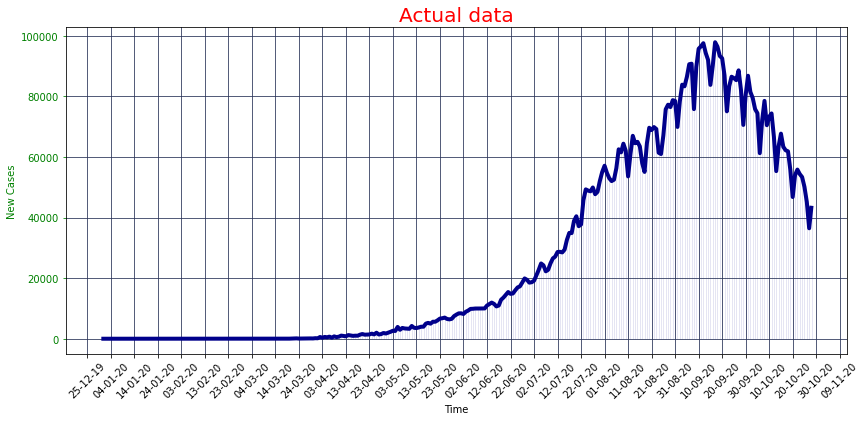

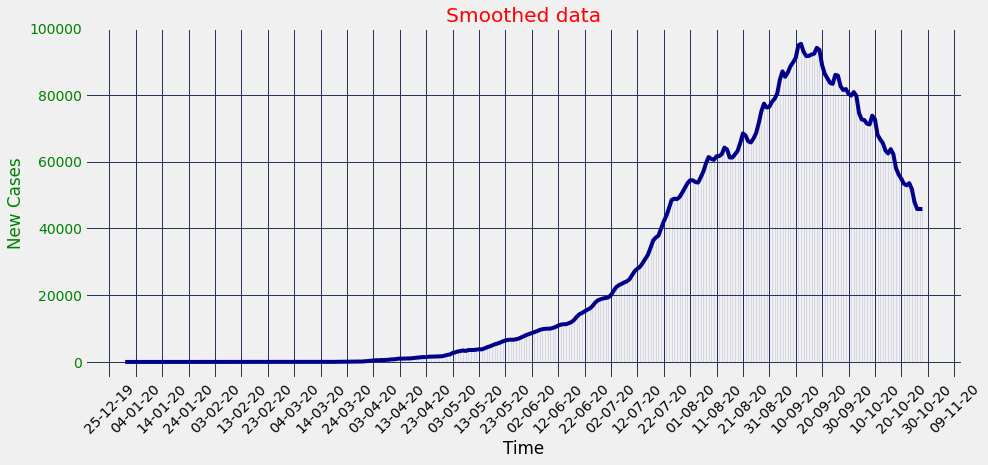

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [ ]:
starting_date = "31122019"
india = timeSeriesPredict("india")
india.series,india.dates = get_series('/content/India.csv')
plot(india.series[:,0],india.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
india.series = moving_average(india.series,5)
plot(india.series[:,0],india.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
india.x,india.y = create_windowed_dataset(india.series,window_size,0)
india.x_train,india.x_val,india.y_train,india.y_val = train_test_split(ratio,india.x,india.y)
india.model = get_model()
india.model.summary()
india.epochs = 1000
india.split_time = int(india.x.shape[0] * ratio)

In [ ]:
train_model(india)

Epoch 1/1000
1/1 [==============================] - 0s 179ms/step - loss: 704145536.0000 - mse: 704145536.0000 - val_loss: 2168502528.0000 - val_mse: 2168502528.0000
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 704094144.0000 - mse: 704094144.0000 - val_loss: 2169218048.0000 - val_mse: 2169218048.0000
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 704116864.0000 - mse: 704116864.0000 - val_loss: 2169362432.0000 - val_mse: 2169362432.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 704126912.0000 - mse: 704126912.0000 - val_loss: 2168338432.0000 - val_mse: 2168338432.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 704018048.0000 - mse: 704018048.0000 - val_loss: 2168345600.0000 - val_mse: 2168345600.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 704044992.0000 - mse: 704044992.0000 - val_loss: 2168360704.0000 - val_mse: 2168360704.0000
Epoch 7/1

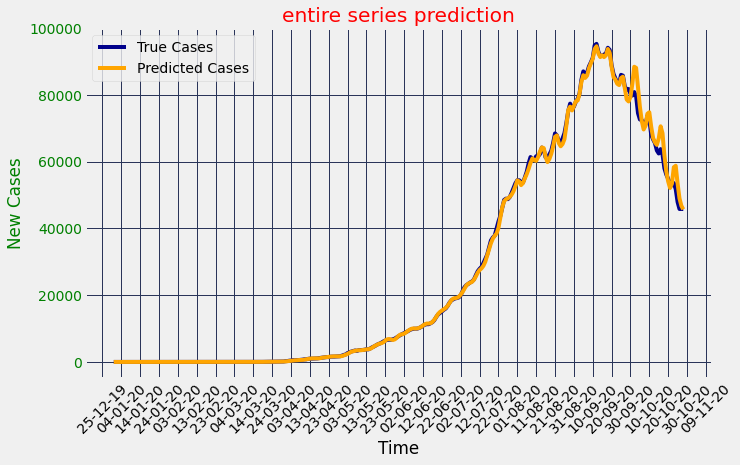

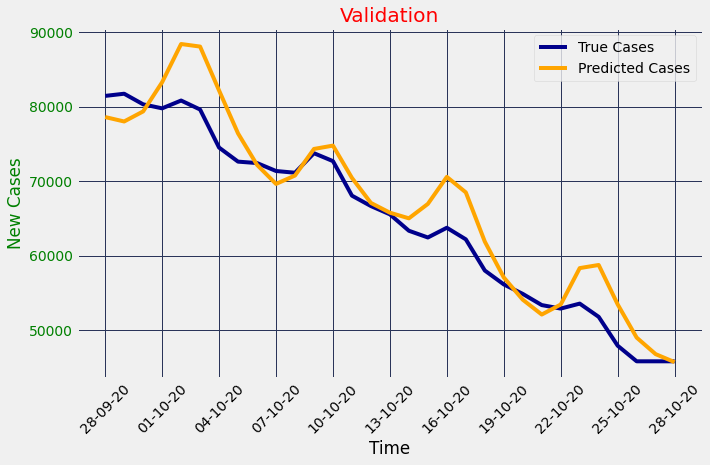

(303, 2)


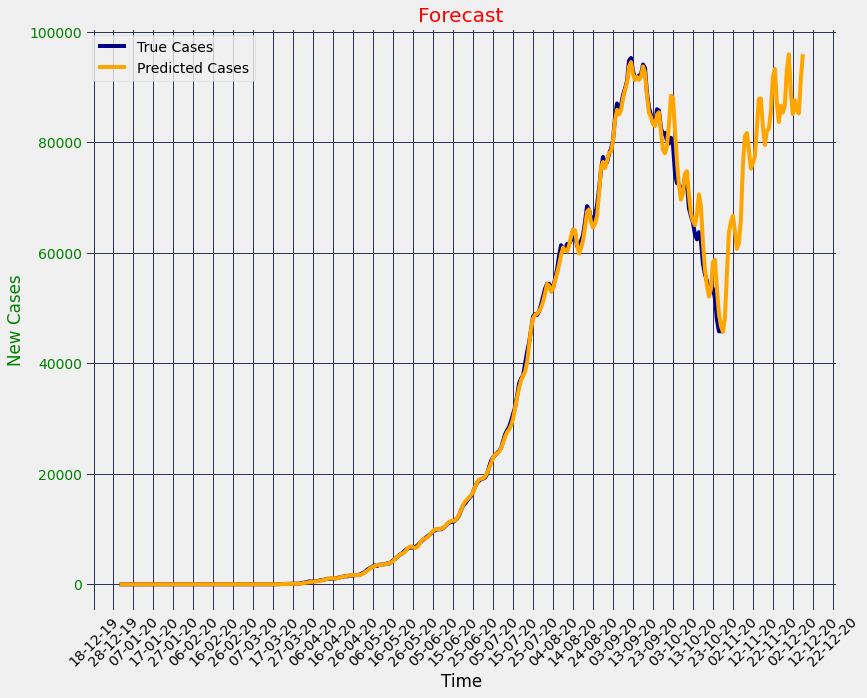

(0.05046885343236214,
 0.05936868343256017,
 5.581952424819434,
 4.764217195863144)

In [ ]:
show_plots(india)

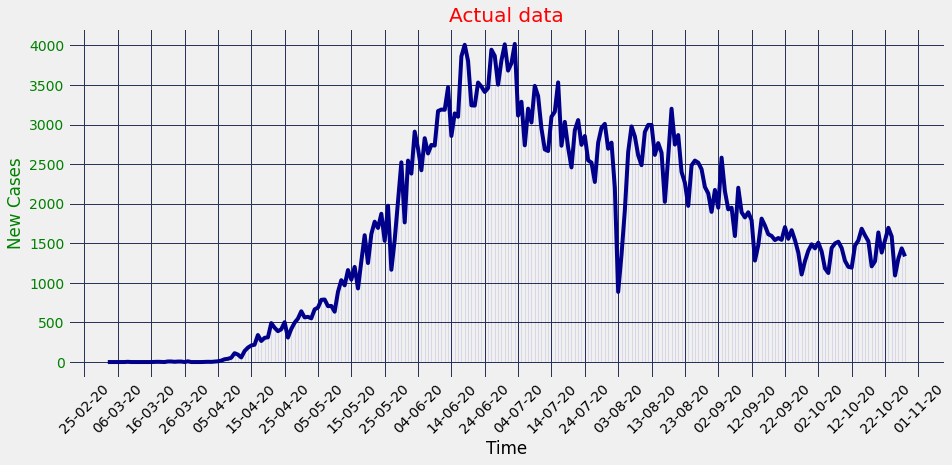

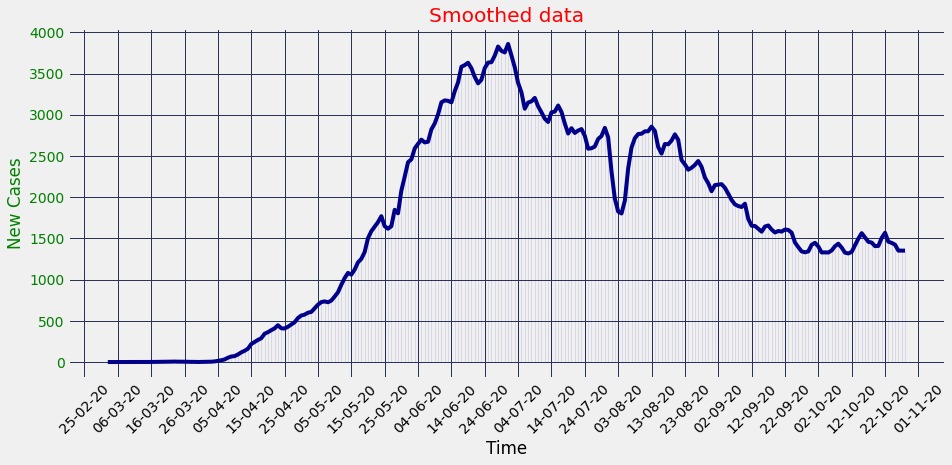

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [ ]:
starting_date = "03032020"
bangladesh = timeSeriesPredict("Bangladesh")
country = bangladesh
country.series,country.dates = get_series('/content/Bangladesh.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 149ms/step - loss: 2105281.5000 - mse: 2105281.5000 - val_loss: 535568.4375 - val_mse: 535568.4375
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 1184052.2500 - mse: 1184052.2500 - val_loss: 235583.8281 - val_mse: 235583.8281
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 597382.6875 - mse: 597382.6875 - val_loss: 69952.3047 - val_mse: 69952.3047
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 211339.8594 - mse: 211339.8594 - val_loss: 134807.2656 - val_mse: 134807.2656
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 342526.2188 - mse: 342526.2188 - val_loss: 16025.1133 - val_mse: 16025.1133
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 98756.4375 - mse: 98756.4375 - val_loss: 170775.1406 - val_mse: 170775.1406
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - loss: 449085.3750 - mse: 449

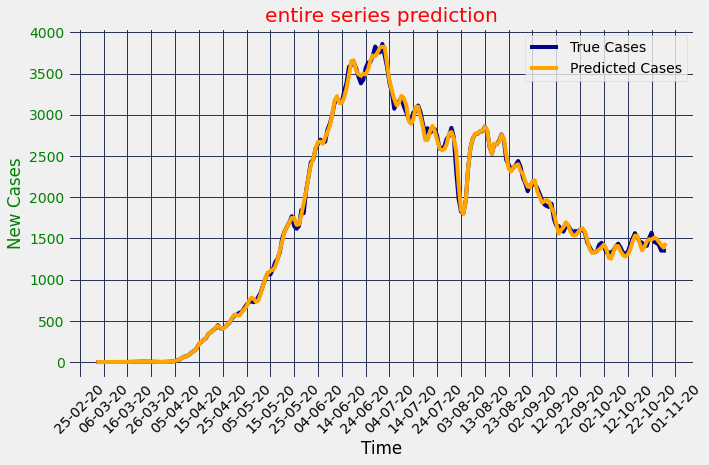

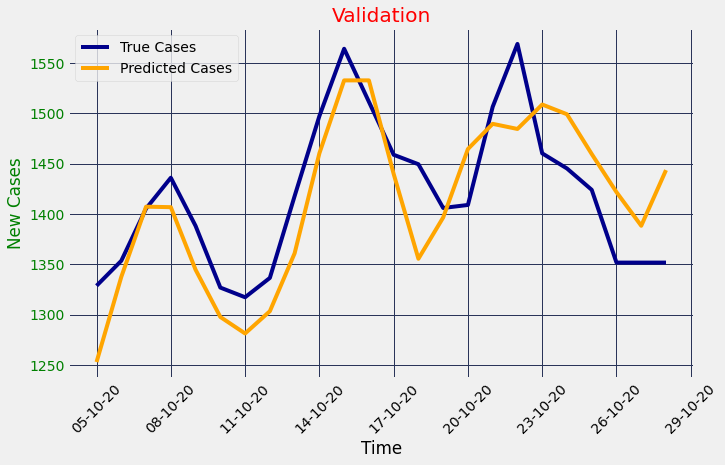

(240, 2)


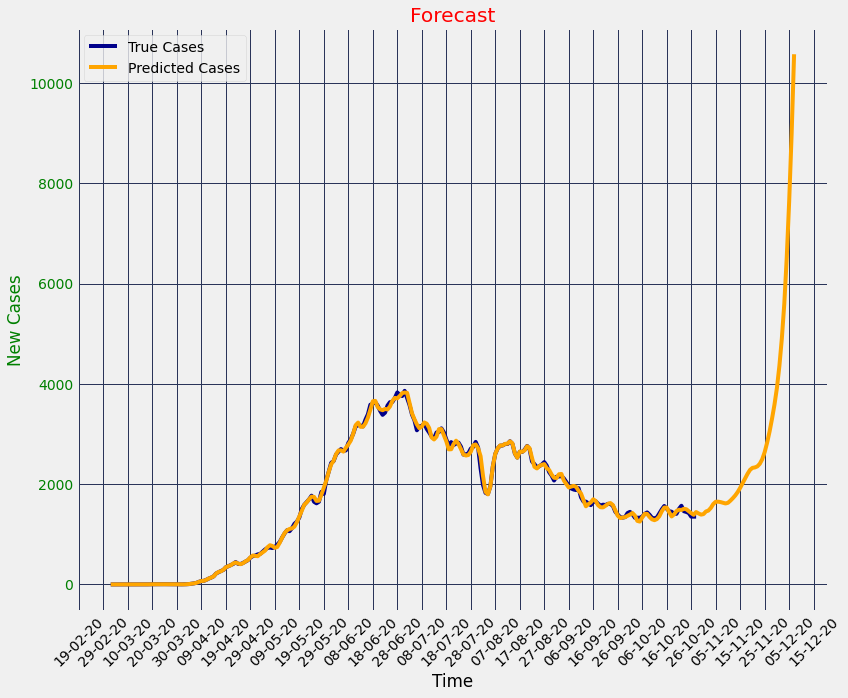

(0.026376265161974416,
 0.03509738450667113,
 6.060255265749906,
 3.0227982550680643)

In [ ]:
show_plots(bangladesh)


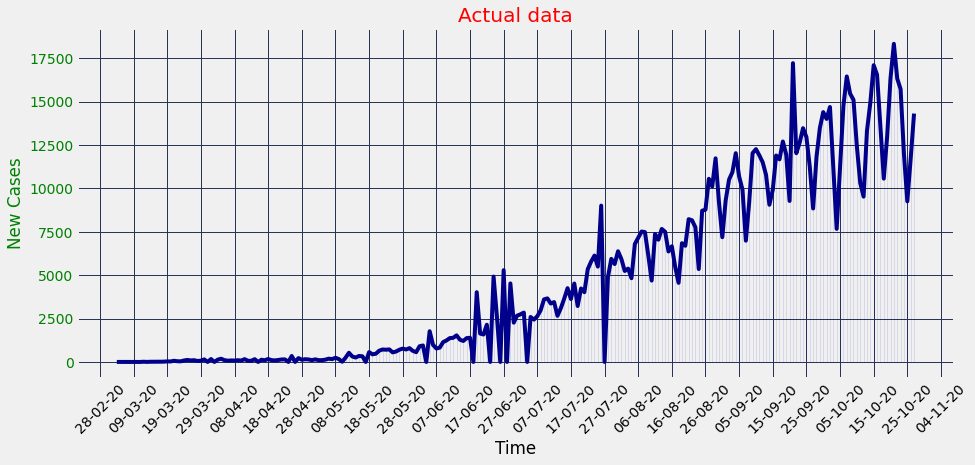

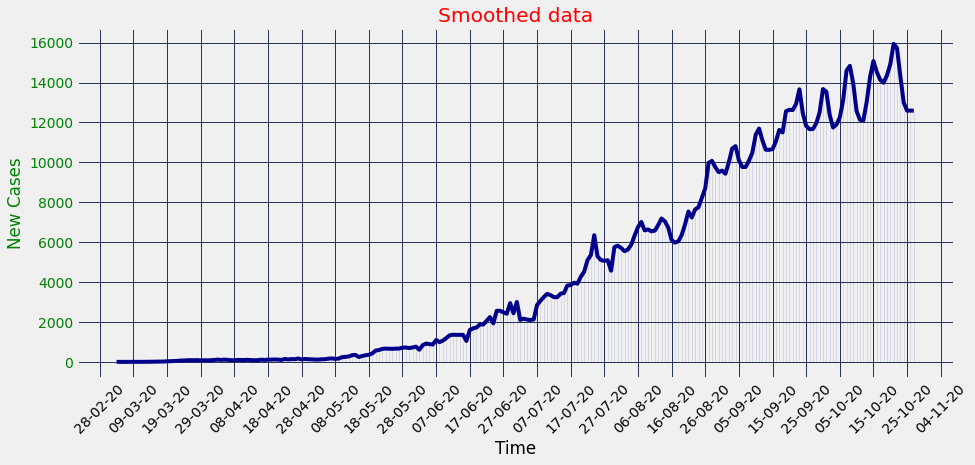

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [ ]:
starting_date = "04032020"
argentina = timeSeriesPredict("Argentina")
country = argentina
country.series,country.dates = get_series('/content/Argentina.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(argentina)

Epoch 1/1000
1/1 [==============================] - 0s 143ms/step - loss: 15596361.0000 - mse: 15596361.0000 - val_loss: 30178842.0000 - val_mse: 30178842.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 5688431.5000 - mse: 5688431.5000 - val_loss: 150182384.0000 - val_mse: 150182384.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 17852738.0000 - mse: 17852738.0000 - val_loss: 4210753.0000 - val_mse: 4210753.0000
Epoch 4/1000
1/1 [==============================] - 0s 22ms/step - loss: 1158662.3750 - mse: 1158662.3750 - val_loss: 25916798.0000 - val_mse: 25916798.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 5100243.5000 - mse: 5100243.5000 - val_loss: 22673978.0000 - val_mse: 22673978.0000
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 4586383.5000 - mse: 4586383.5000 - val_loss: 3778486.7500 - val_mse: 3778486.7500
Epoch 7/1000
1/1 [==============================] - 0s 

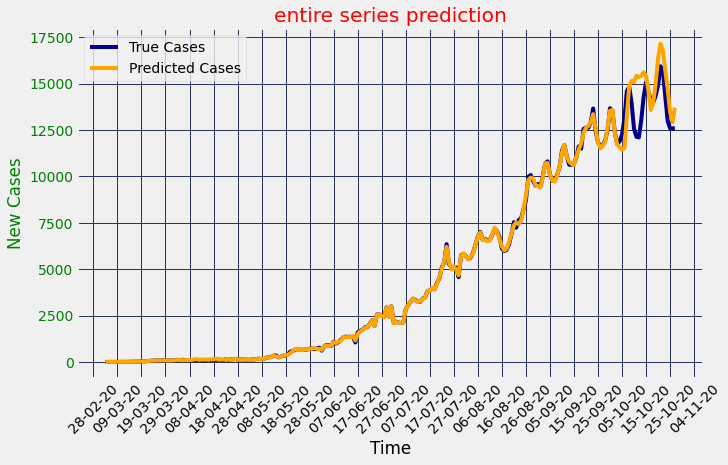

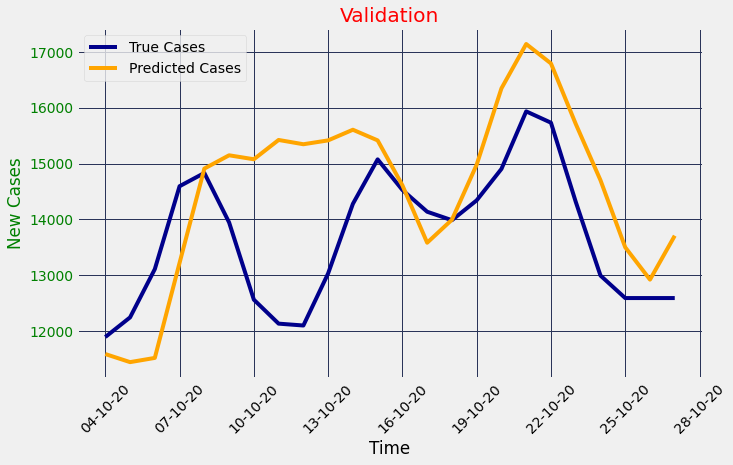

(238, 2)


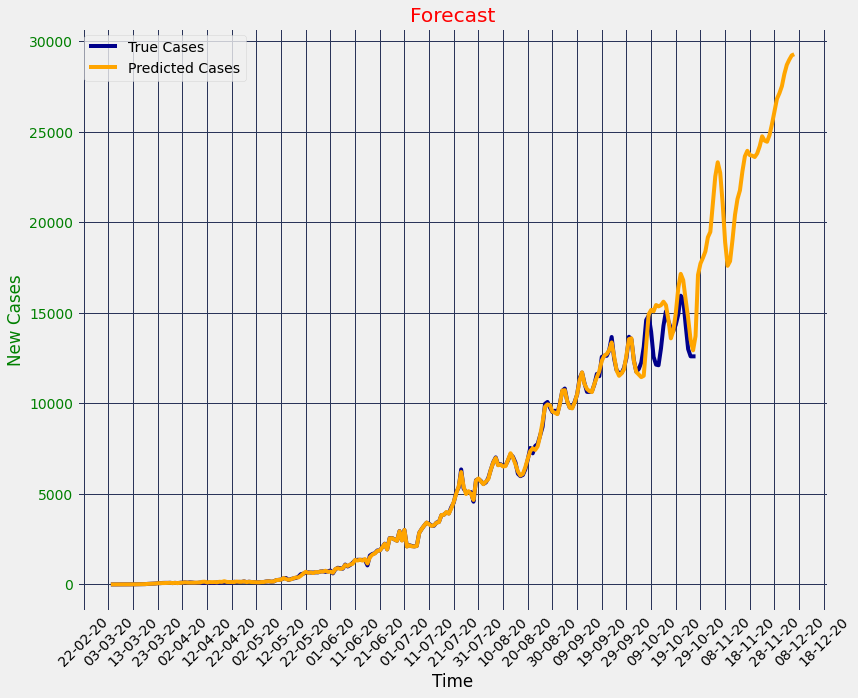

(0.10097523503905624,
 0.10373198432746618,
 5.398166822902803,
 9.096721406383617)

In [ ]:
show_plots(argentina)

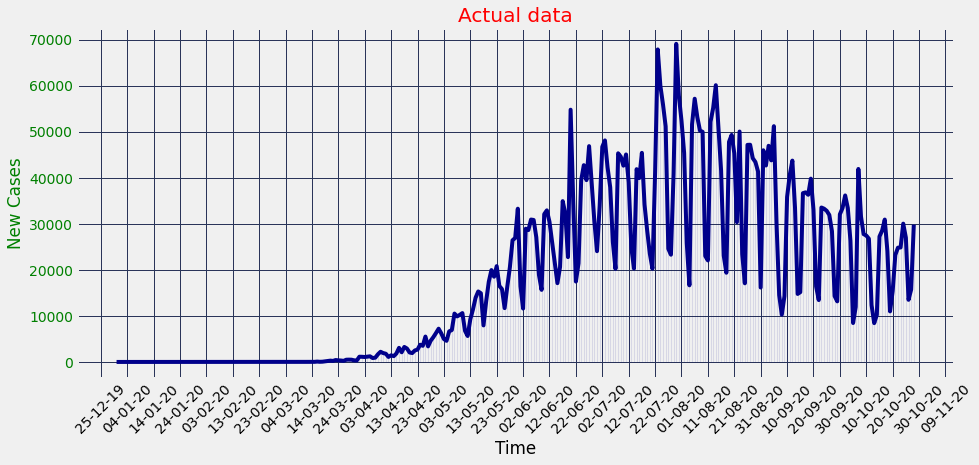

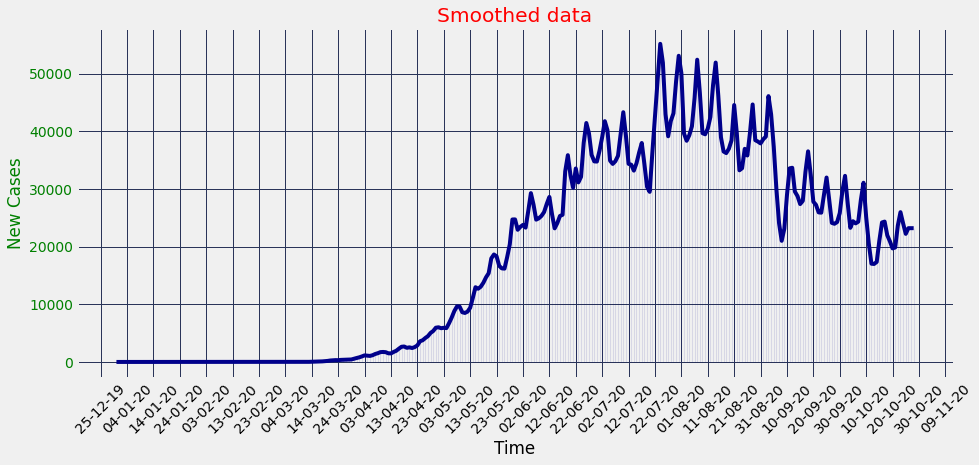

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [ ]:
starting_date = "31122019"
brazil = timeSeriesPredict("Brazil")
country = brazil
country.series,country.dates = get_series('/content/Brazil.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 144ms/step - loss: 300197120.0000 - mse: 300197120.0000 - val_loss: 293130240.0000 - val_mse: 293130240.0000
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 305304448.0000 - mse: 305304448.0000 - val_loss: 254943104.0000 - val_mse: 254943104.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 270460032.0000 - mse: 270460032.0000 - val_loss: 161192528.0000 - val_mse: 161192528.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - loss: 181554176.0000 - mse: 181554176.0000 - val_loss: 7455558.5000 - val_mse: 7455558.5000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 11710157.0000 - mse: 11710157.0000 - val_loss: 1594065024.0000 - val_mse: 1594065024.0000
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 1223378688.0000 - mse: 1223378688.0000 - val_loss: 50168916.0000 - val_mse: 50168916.0000
Epoch 7/1000
1/1 [=======

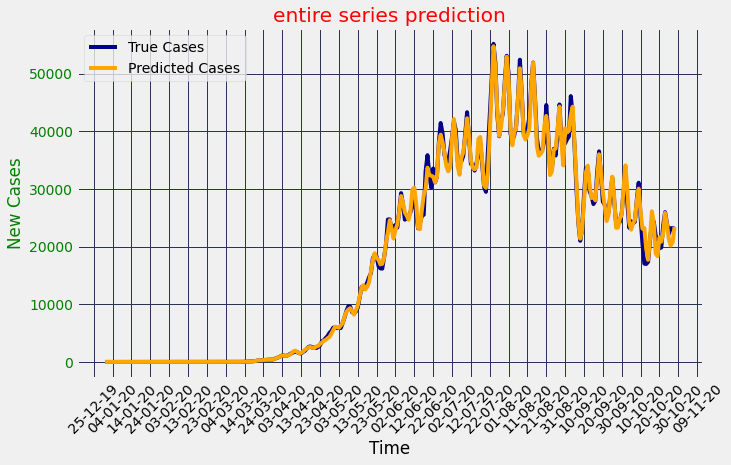

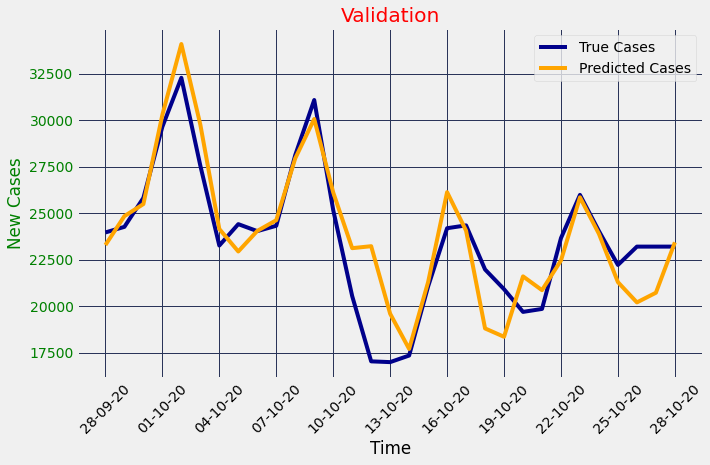

(303, 2)


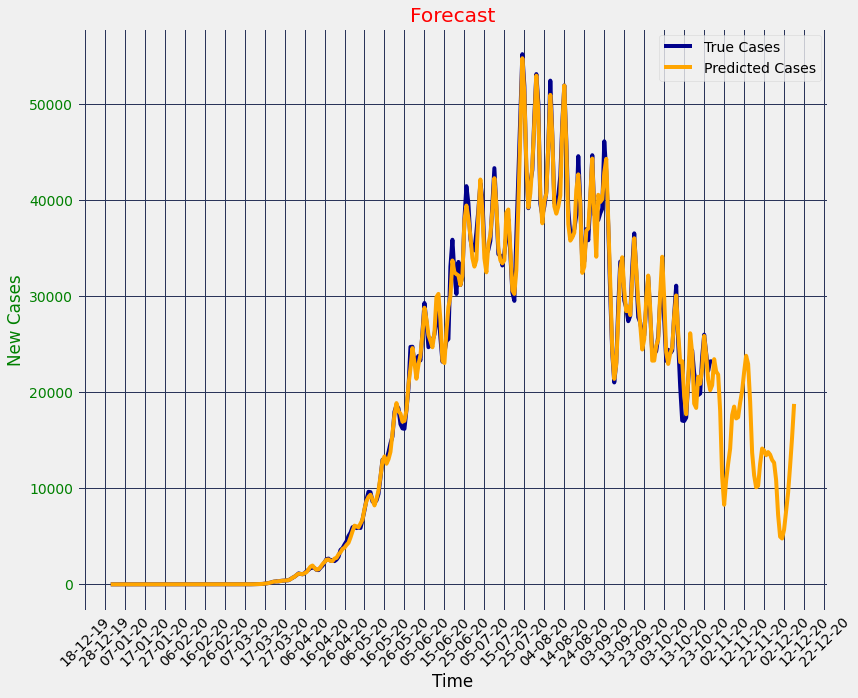

(0.05766869835124367,
 0.0784997431794578,
 5.5459391493009855,
 6.254891810631777)

In [ ]:
show_plots(brazil)

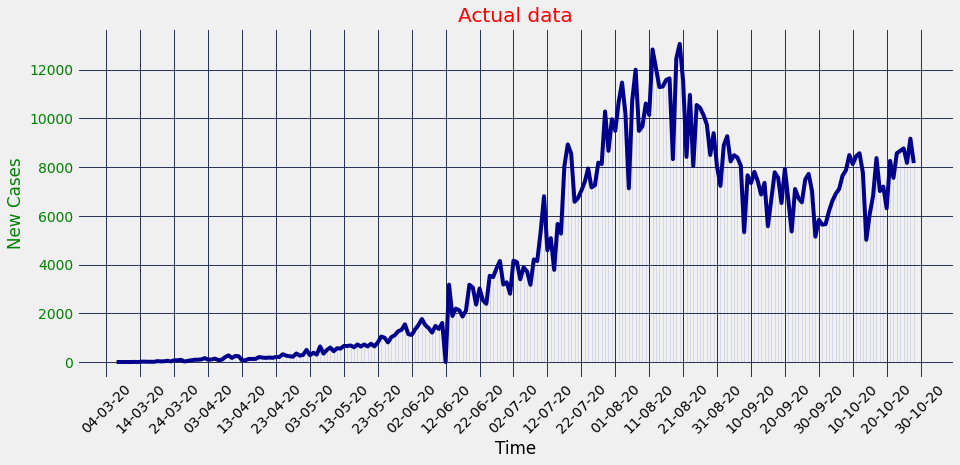

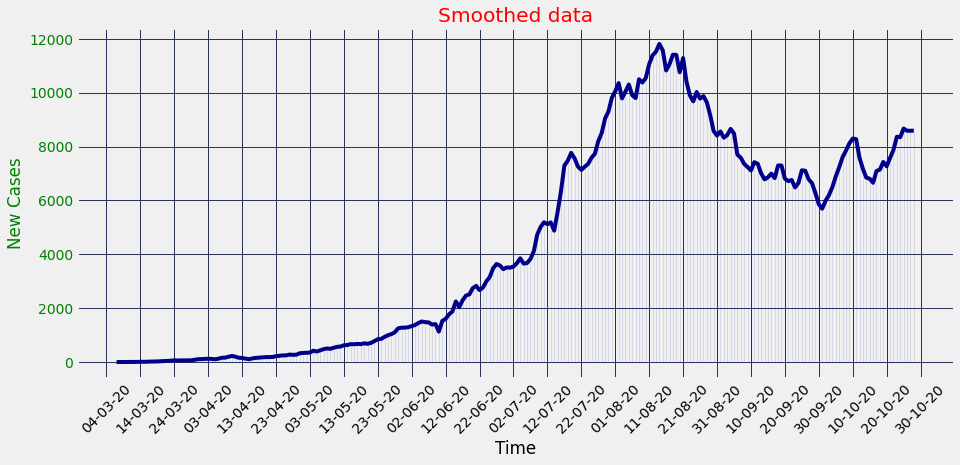

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [ ]:
starting_date = "07032020"
colombia = timeSeriesPredict("Colombia")
country = colombia
country.series,country.dates = get_series('/content/Colombia.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [19]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 149ms/step - loss: 15480636.0000 - mse: 15480636.0000 - val_loss: 31296088.0000 - val_mse: 31296088.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 16225403.0000 - mse: 16225403.0000 - val_loss: 22091168.0000 - val_mse: 22091168.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 11298765.0000 - mse: 11298765.0000 - val_loss: 14822925.0000 - val_mse: 14822925.0000
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 7824221.0000 - mse: 7824221.0000 - val_loss: 18302678.0000 - val_mse: 18302678.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 10569908.0000 - mse: 10569908.0000 - val_loss: 13256297.0000 - val_mse: 13256297.0000
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 6752523.5000 - mse: 6752523.5000 - val_loss: 15284339.0000 - val_mse: 15284339.0000
Epoch 7/1000
1/1 [==============================]

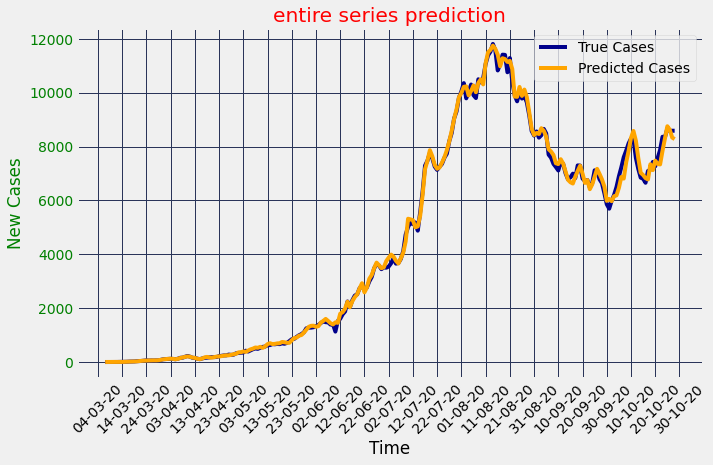

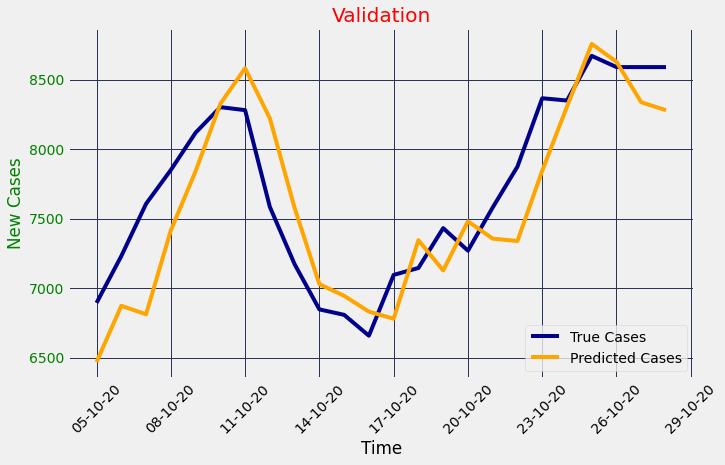

(236, 2)


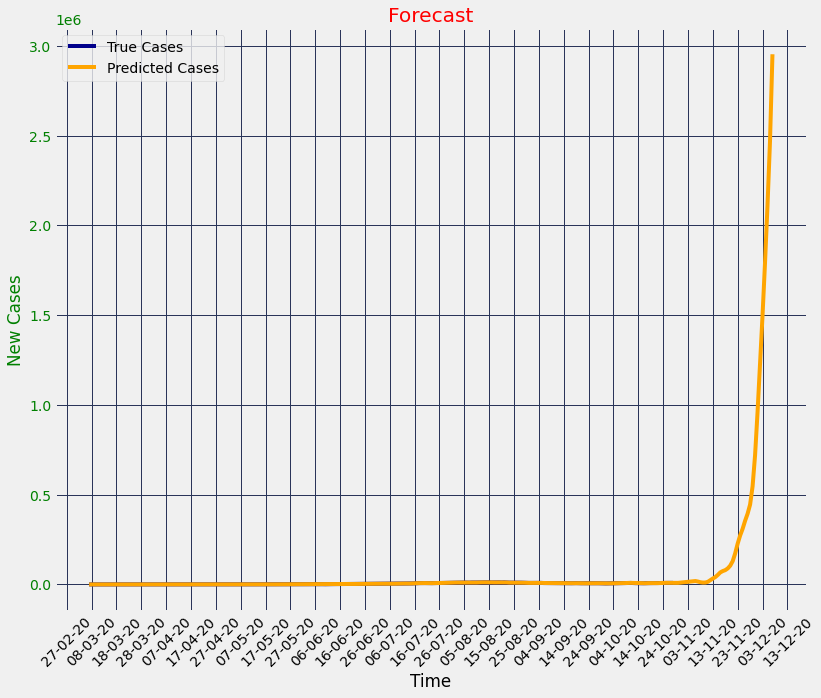

(0.03797441449994422,
 0.04653385573648708,
 9.667090353816455,
 3.9371475845684225)

In [20]:
show_plots(colombia)

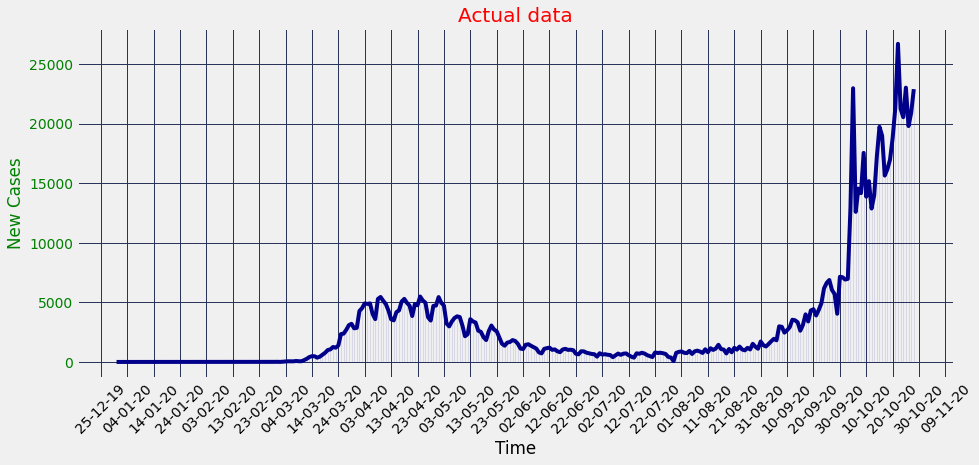

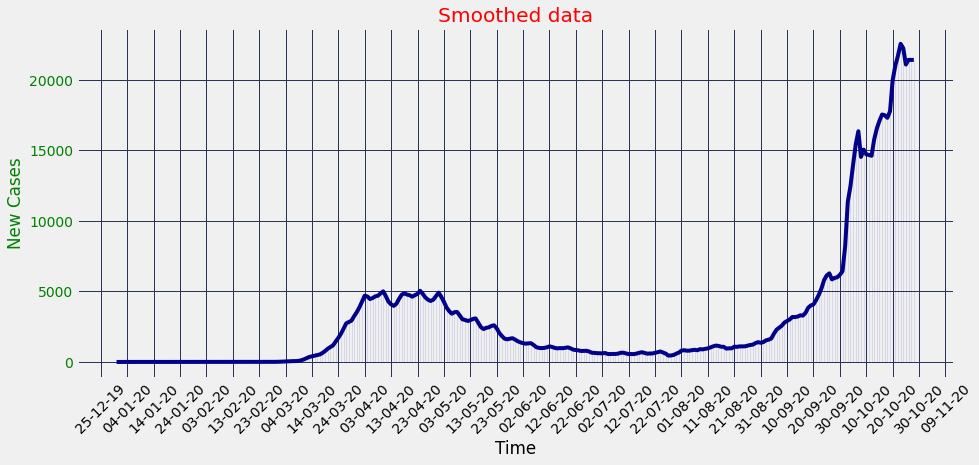

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [21]:
starting_date = "31122019"
uk = timeSeriesPredict("UK")
country = uk
country.series,country.dates = get_series('/content/United Kingdom.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [22]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 148ms/step - loss: 2650986.2500 - mse: 2650986.2500 - val_loss: 144090816.0000 - val_mse: 144090816.0000
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 2719559.0000 - mse: 2719559.0000 - val_loss: 136470144.0000 - val_mse: 136470144.0000
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 2646269.7500 - mse: 2646269.7500 - val_loss: 125980392.0000 - val_mse: 125980392.0000
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 2423370.7500 - mse: 2423370.7500 - val_loss: 100713768.0000 - val_mse: 100713768.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 1891515.6250 - mse: 1891515.6250 - val_loss: 31809680.0000 - val_mse: 31809680.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 586492.6875 - mse: 586492.6875 - val_loss: 133350584.0000 - val_mse: 133350584.0000
Epoch 7/1000
1/1 [==============================]

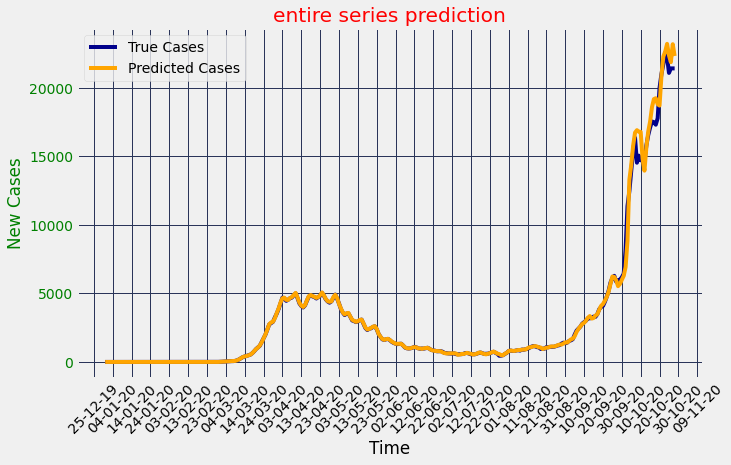

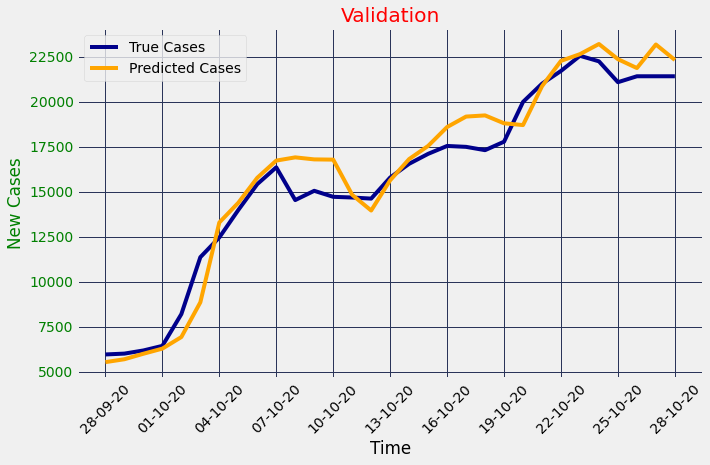

(303, 2)


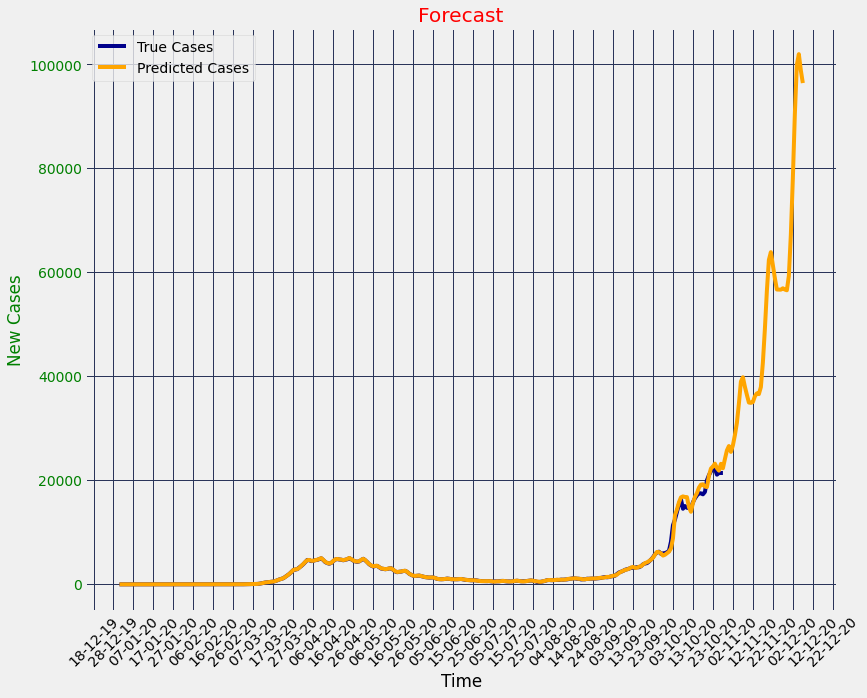

(0.11918531413843719,
 0.07056832351191997,
 9.566264486421996,
 6.118876017507395)

In [23]:
show_plots(uk)

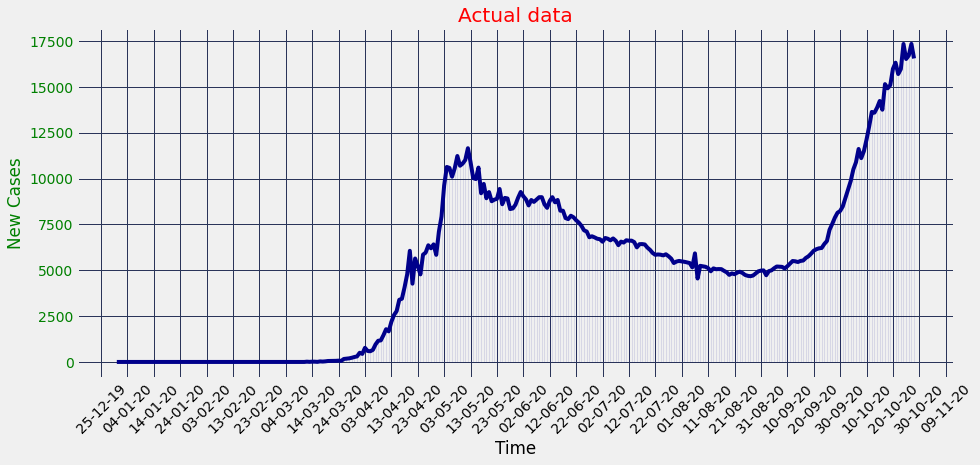

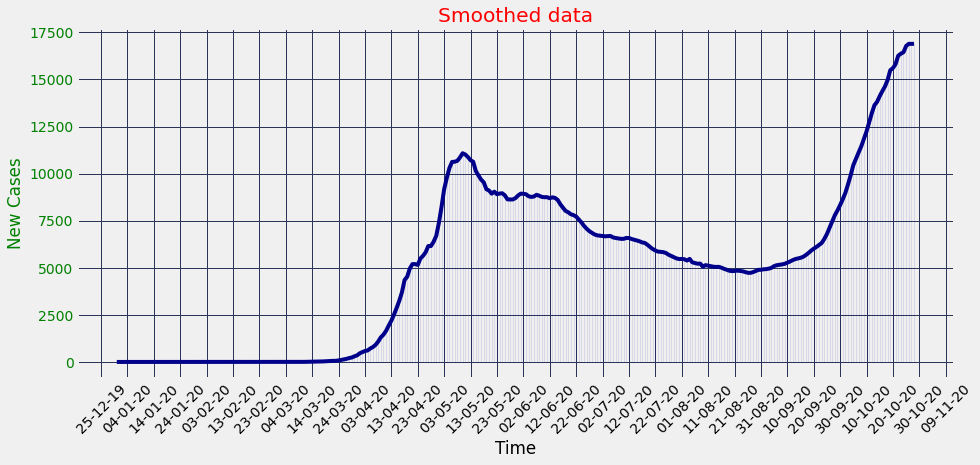

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 2, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 1, 16)         80        
_________________________________________________________________
lambda_1 (Lambda)            (None, 19, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 256)           9

In [24]:
starting_date = "31122019"
russia = timeSeriesPredict("Russia")
country = russia
country.series,country.dates = get_series('/content/Russia.csv')
plot(country.series[:,0],country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series[:,0],country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 139ms/step - loss: 14880412.0000 - mse: 14880412.0000 - val_loss: 45925336.0000 - val_mse: 45925336.0000
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 6378803.0000 - mse: 6378803.0000 - val_loss: 24149330.0000 - val_mse: 24149330.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 14375177.0000 - mse: 14375177.0000 - val_loss: 19021020.0000 - val_mse: 19021020.0000
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 1936769.3750 - mse: 1936769.3750 - val_loss: 46328652.0000 - val_mse: 46328652.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 6485426.5000 - mse: 6485426.5000 - val_loss: 50469232.0000 - val_mse: 50469232.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 7281268.0000 - mse: 7281268.0000 - val_loss: 31782938.0000 - val_mse: 31782938.0000
Epoch 7/1000
1/1 [==============================] - 0

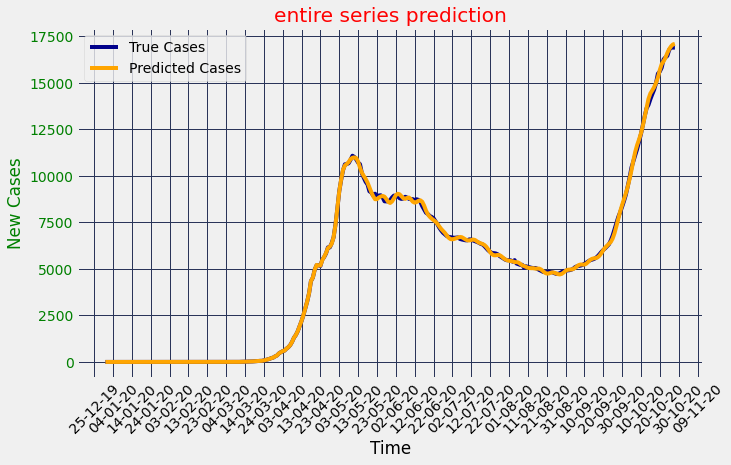

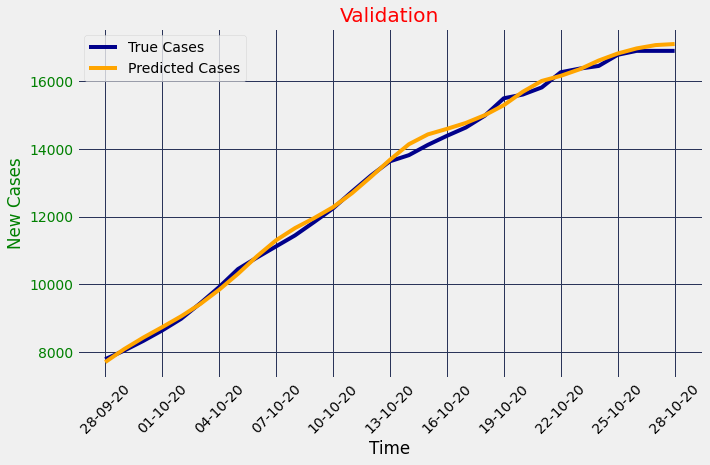

(303, 2)


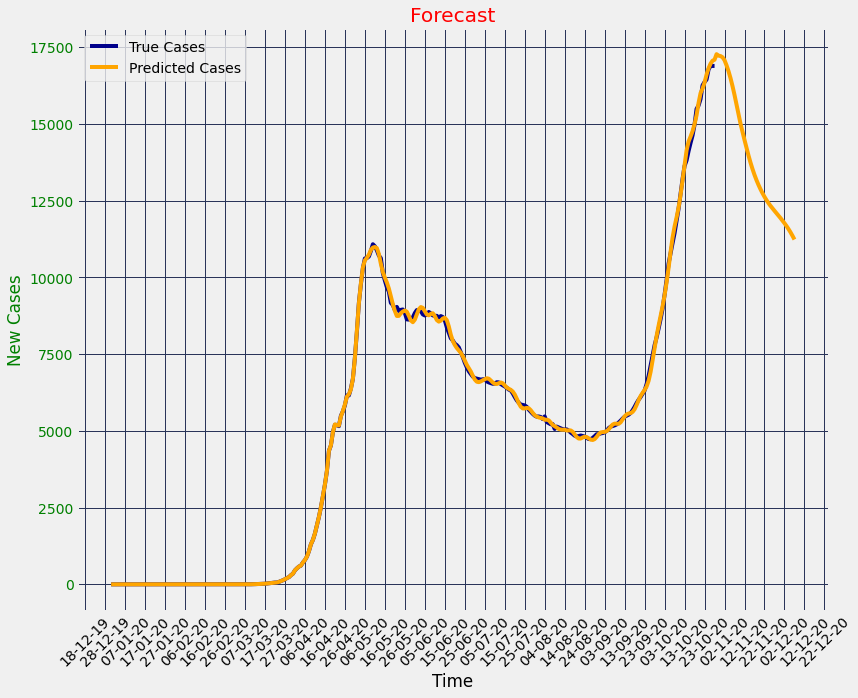

(0.014936484145911914,
 0.01079377944048414,
 4.846048503891003,
 0.8984122704841769)

In [26]:
show_plots(russia)